In [97]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import math

torch.manual_seed(0)

In [98]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mu = torch.tensor(0.01)

In [99]:
class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet,self).__init__()
        self.Branch_L1 = nn.Linear(100,20)
        self.Branch_L2 = nn.Linear(20,20)
        self.Branch_L3 = nn.Linear(20,20)
        self.Branch_L4 = nn.Linear(20,20)
        self.Branch_L5 = nn.Linear(20,100)

        self.Trunk_L1 = nn.Linear(2,20)
        self.Trunk_L2 = nn.Linear(20,20)
        self.Trunk_L3 = nn.Linear(20,20)
        self.Trunk_L4 = nn.Linear(20,20)
        self.Trunk_L5 = nn.Linear(20,100)

    def forward(self,y_0,x_loc_and_time):
        # Branch
        b = F.tanh(self.Branch_L1(y_0))
        b = F.tanh(self.Branch_L2(b))
        b = F.tanh(self.Branch_L3(b))
        b = F.tanh(self.Branch_L4(b))
        b = self.Branch_L5(b)

        tr = F.tanh(self.Trunk_L1(x_loc_and_time))
        tr = F.tanh(self.Trunk_L2(tr))
        tr = F.tanh(self.Trunk_L3(tr))
        tr = F.tanh(self.Trunk_L4(tr))
        tr = self.Trunk_L5(tr)

        #output = torch.matmul(b,tr.t()).sum(dim=0)
        output = torch.sum(b * tr, dim=1)

        return output

model = DeepONet().to(device)

In [100]:
model = DeepONet().to(device)

In [101]:
database = pd.read_csv('sin_pix.csv',index_col=0).dropna().to_numpy(dtype='float32')

In [102]:
database.shape

(33000, 103)

In [103]:
class Data(Dataset):
    def __init__(self,transform=None):
        self.initial_conditions = torch.from_numpy(database[:,0:100])#.requires_grad_(True)
        self.x_location = torch.from_numpy(database[:,[100]])#.requires_grad_(True)
        self.time_vale = torch.from_numpy(database[:,[101]])#.requires_grad_(True)
        self.true_y_value = torch.from_numpy(database[:,[102]])#.requires_grad_(True)
        self.n_samples = database.shape[0]

    def __getitem__(self, index):
        return self.initial_conditions[index] , self.x_location[index] , self.time_vale[index] , self.true_y_value[index]
    
    def __len__(self):
        return self.n_samples

In [104]:
dataset_data = Data()

In [105]:
dataset_data.__len__()

33000

In [106]:
y,_,_,_ = dataset_data.__getitem__(1)
#plt.plot(y)
#plt.grid()

In [107]:
train_size = int(0.7*dataset_data.__len__())
test_size = dataset_data.__len__() - train_size

batch_size = test_size

Burger_train_data , Burger_test_data = torch.utils.data.random_split(Data(),[train_size,test_size])

train_loader = DataLoader(dataset=Burger_train_data,batch_size=batch_size,shuffle=True)

In [108]:
data_iter = iter(train_loader)
data = data_iter.__next__()
Init_val , x_loc, time, y_value = data

In [109]:
num_epoch = 10000
total_samples = len(train_loader)
n_iterations = math.ceil(total_samples/300)
print(total_samples,n_iterations)
learning_rate = 0.01

criterion = nn.MSELoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.00001)

loss_rec = []

3 1


In [110]:
def grad(outputs,inputs):
    return torch.autograd.grad(outputs,inputs,grad_outputs=torch.ones_like(outputs),create_graph=True)

In [111]:
def Physics_loss(init_conditions,time_input_physics):
    for j in range(3):
        x_locations = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)
        time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
        input_1_physics = init_conditions.unsqueeze(0)
        input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
        output_physics = model(input_1_physics,input2_physics)
        du_dt = grad(output_physics,time_input)[0]
        du_dx = grad(output_physics,x_locations)[0]
        du2_dx2 = grad(du_dx,x_locations)[0]
        return torch.mean(du_dt + output_physics*du_dx - mu*du2_dx2)

In [112]:
#time_input

In [113]:
x_locations = torch.linspace(0,1,300,dtype=torch.float32).requires_grad_(True)

In [114]:
time_input_physics = torch.tensor(0.2)
time_input = time_input_physics*torch.ones_like(x_locations,dtype=torch.float32).requires_grad_(True)
print(time_input)

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.2000,
        0.2000, 0.2000, 0.2000, 0.2000, 

In [115]:
input2_physics = torch.cat((x_locations.unsqueeze(-1),time_input.unsqueeze(-1)),-1)
print(input2_physics)

tensor([[0.0000, 0.2000],
        [0.0033, 0.2000],
        [0.0067, 0.2000],
        [0.0100, 0.2000],
        [0.0134, 0.2000],
        [0.0167, 0.2000],
        [0.0201, 0.2000],
        [0.0234, 0.2000],
        [0.0268, 0.2000],
        [0.0301, 0.2000],
        [0.0334, 0.2000],
        [0.0368, 0.2000],
        [0.0401, 0.2000],
        [0.0435, 0.2000],
        [0.0468, 0.2000],
        [0.0502, 0.2000],
        [0.0535, 0.2000],
        [0.0569, 0.2000],
        [0.0602, 0.2000],
        [0.0635, 0.2000],
        [0.0669, 0.2000],
        [0.0702, 0.2000],
        [0.0736, 0.2000],
        [0.0769, 0.2000],
        [0.0803, 0.2000],
        [0.0836, 0.2000],
        [0.0870, 0.2000],
        [0.0903, 0.2000],
        [0.0936, 0.2000],
        [0.0970, 0.2000],
        [0.1003, 0.2000],
        [0.1037, 0.2000],
        [0.1070, 0.2000],
        [0.1104, 0.2000],
        [0.1137, 0.2000],
        [0.1171, 0.2000],
        [0.1204, 0.2000],
        [0.1237, 0.2000],
        [0.1

In [116]:
input_1_physics = input1[1,:].unsqueeze(0)
input_1_physics.shape

torch.Size([1, 100])

In [117]:
output_physics = model(input_1_physics,input2_physics)

In [118]:
du_dt = grad(output_physics,time_input)[0]
du_dx = grad(output_physics,x_locations)[0]
du2_dx2 = grad(du_dx,x_locations)[0]
loss_physics_burgers = torch.mean(du_dt + x_locations*du_dx - mu*du2_dx2)
loss_physics_burgers

tensor(0.0167, grad_fn=<MeanBackward0>)

In [119]:
input1[3]

tensor([-1.2246e-16, -6.3424e-02, -1.2659e-01, -1.8925e-01, -2.5115e-01,
        -3.1203e-01, -3.7166e-01, -4.2979e-01, -4.8620e-01, -5.4064e-01,
        -5.9291e-01, -6.4279e-01, -6.9008e-01, -7.3459e-01, -7.7615e-01,
        -8.1458e-01, -8.4973e-01, -8.8145e-01, -9.0963e-01, -9.3415e-01,
        -9.5490e-01, -9.7181e-01, -9.8481e-01, -9.9384e-01, -9.9887e-01,
        -9.9987e-01, -9.9685e-01, -9.8982e-01, -9.7880e-01, -9.6384e-01,
        -9.4500e-01, -9.2235e-01, -8.9599e-01, -8.6603e-01, -8.3257e-01,
        -7.9576e-01, -7.5575e-01, -7.1269e-01, -6.6677e-01, -6.1816e-01,
        -5.6706e-01, -5.1368e-01, -4.5823e-01, -4.0093e-01, -3.4202e-01,
        -2.8173e-01, -2.2031e-01, -1.5800e-01, -9.5056e-02, -3.1728e-02,
         3.1728e-02,  9.5056e-02,  1.5800e-01,  2.2031e-01,  2.8173e-01,
         3.4202e-01,  4.0093e-01,  4.5823e-01,  5.1368e-01,  5.6706e-01,
         6.1816e-01,  6.6677e-01,  7.1269e-01,  7.5575e-01,  7.9576e-01,
         8.3257e-01,  8.6603e-01,  8.9599e-01,  9.2

In [120]:
Physics_loss_rec = Physics_loss(input1,input_time[3])
Physics_loss_rec

RuntimeError: The size of tensor a (23100) must match the size of tensor b (300) at non-singleton dimension 1

In [121]:
model.train()

for epoch in range(num_epoch):
    for i , (input_init_conditions,input_x_loc,input_time,Actual_y) in enumerate(train_loader):
        input1 = input_init_conditions
        input1 = input1.to(device)

        input2 = torch.cat((input_x_loc,input_time),-1)
        input2 = input2.to(device)

        Actual_y = Actual_y.to(device)

        Outputs = model(input1,input2)

        input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)
        target_BC1 = torch.zeros(input_time.size(0))
        predicted_BC1 = model(input1,input2_BC1)
        loss_BC1 = torch.mean((predicted_BC1-target_BC1)**2)

        input2_BC2 = torch.cat((torch.ones(input_time.size(0),1),input_time),-1).to(device)
        target_BC2 = torch.zeros(input_time.size(0))
        predicted_BC2 = model(input1,input2_BC2)
        loss_BC2 = torch.mean((predicted_BC2-target_BC2)**2)

        #Physics_loss = 

        #Physics_loss = torch.mean()
        
        loss = criterion(Outputs,Actual_y) # + 1000*(loss_BC1 + loss_BC2)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()    

        loss_rec.append(loss.item())

        if (i+1) % 10 ==0:
            print(f'Epoch [{epoch+1}/{num_epoch}] , Step [{i+1}/{total_samples}] , Loss: {loss.item():.16f}')

c:\Users\dell\anaconda3\envs\abhi\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([9900, 1])) that is different to the input size (torch.Size([9900])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\dell\anaconda3\envs\abhi\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([3300, 1])) that is different to the input size (torch.Size([3300])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 

In [88]:
y_locations_test = model(input1[1],input2_physics)

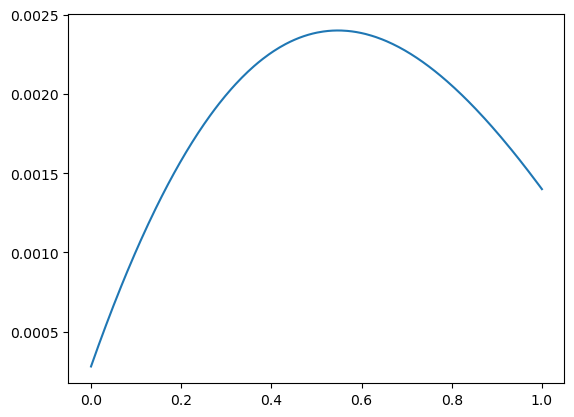

In [93]:
plt.plot(x_locations.detach().numpy(),y_locations_test.detach().numpy())

In [14]:
input_time.size(0)
torch.ones(input_time.size(0),1)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
      

In [15]:
input2_BC1 = torch.cat((torch.zeros(input_time.size(0),1),input_time),-1).to(device)
input2_BC1

tensor([[0.0000, 0.2004],
        [0.0000, 0.0531],
        [0.0000, 0.3126],
        ...,
        [0.0000, 0.1533],
        [0.0000, 0.3146],
        [0.0000, 0.2024]])

In [16]:
target_BC1 = torch.zeros(input_time.size(0))
target_BC1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [17]:
predicted_BC1 = model(input1,input2_BC1)
# predicted_BC1
loss_BC1 = torch.mean((predicted_BC1-target_BC1)**2)
loss_BC1

tensor(5.6292e-06, grad_fn=<MeanBackward0>)

In [18]:
#loss_BC_0 = torch.mean()

In [19]:
input2.size()

torch.Size([600, 2])

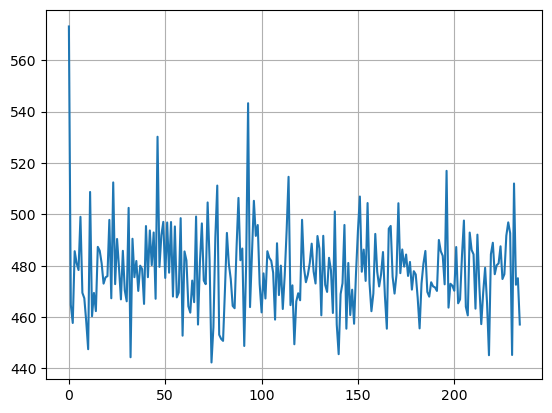

In [44]:
plt.plot(loss_rec)
plt.grid()

In [21]:
# model(y,torch.tensor([0,0]))

In [22]:
trial_input_1 = torch.tensor(np.random.rand(65,100),dtype=torch.float32).to(device)
trial_input_2 = torch.tensor(np.random.rand(65,2),dtype=torch.float32).to(device)
model(trial_input_1,trial_input_2).mean()
model(trial_input_1,trial_input_2).shape

torch.Size([65])